In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
import keras.backend as K

Using TensorFlow backend.


In [3]:
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english'))

### Data

In [4]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

### Remove Stopwords and Do Tokenization

In [5]:
def clean_corpus(corpus):
    filtered_sentence = [] 
    for c in corpus:
        word_tokens = word_tokenize(c) 
        tokens_without_sw = []
        for w in word_tokens:
            if w not in stop_words: 
                tokens_without_sw.append(w)
        filtered_sentence.append((" ").join(tokens_without_sw))

    return filtered_sentence

In [6]:
filtered_sentence = clean_corpus(corpus)
filtered_sentence

['king strong man',
 'queen wise woman',
 'boy young man',
 'girl young woman',
 'prince young king',
 'princess young queen',
 'man strong',
 'woman pretty',
 'prince boy king',
 'princess girl queen']

In [7]:
# get unique words
words = []
for text in filtered_sentence:
    for word in text.split(' '):
        words.append(word)

words = set(words)
words

{'boy',
 'girl',
 'king',
 'man',
 'pretty',
 'prince',
 'princess',
 'queen',
 'strong',
 'wise',
 'woman',
 'young'}

### Generate Data For Model

In [8]:
# create word dictionary
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i

word2int

{'woman': 0,
 'man': 1,
 'prince': 2,
 'wise': 3,
 'pretty': 4,
 'princess': 5,
 'strong': 6,
 'queen': 7,
 'king': 8,
 'girl': 9,
 'boy': 10,
 'young': 11}

In [9]:
# sentences with tokenized words
sentences = []
for sentence in filtered_sentence:
    sentences.append(sentence.split())

sentences

[['king', 'strong', 'man'],
 ['queen', 'wise', 'woman'],
 ['boy', 'young', 'man'],
 ['girl', 'young', 'woman'],
 ['prince', 'young', 'king'],
 ['princess', 'young', 'queen'],
 ['man', 'strong'],
 ['woman', 'pretty'],
 ['prince', 'boy', 'king'],
 ['princess', 'girl', 'queen']]

#### SKIP GRAM

In [10]:
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        # get the neighboring words
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])
                
data

[['king', 'strong'],
 ['king', 'man'],
 ['strong', 'king'],
 ['strong', 'man'],
 ['man', 'king'],
 ['man', 'strong'],
 ['queen', 'wise'],
 ['queen', 'woman'],
 ['wise', 'queen'],
 ['wise', 'woman'],
 ['woman', 'queen'],
 ['woman', 'wise'],
 ['boy', 'young'],
 ['boy', 'man'],
 ['young', 'boy'],
 ['young', 'man'],
 ['man', 'boy'],
 ['man', 'young'],
 ['girl', 'young'],
 ['girl', 'woman'],
 ['young', 'girl'],
 ['young', 'woman'],
 ['woman', 'girl'],
 ['woman', 'young'],
 ['prince', 'young'],
 ['prince', 'king'],
 ['young', 'prince'],
 ['young', 'king'],
 ['king', 'prince'],
 ['king', 'young'],
 ['princess', 'young'],
 ['princess', 'queen'],
 ['young', 'princess'],
 ['young', 'queen'],
 ['queen', 'princess'],
 ['queen', 'young'],
 ['man', 'strong'],
 ['strong', 'man'],
 ['woman', 'pretty'],
 ['pretty', 'woman'],
 ['prince', 'boy'],
 ['prince', 'king'],
 ['boy', 'prince'],
 ['boy', 'king'],
 ['king', 'prince'],
 ['king', 'boy'],
 ['princess', 'girl'],
 ['princess', 'queen'],
 ['girl', 'prin

In [11]:
for text in filtered_sentence:
    print(text)

# create dataframe for feeding the model
df = pd.DataFrame(data, columns = ['input', 'label'])
df.head(10)

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


### Prepare Dataset

In [12]:
X = [] # input word
Y = [] # target word

In [13]:
ONE_HOT_DIM = len(words)

In [14]:
# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

In [15]:
for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

In [16]:
# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

In [17]:
print (words)
print (df['input'][0])
print (df['label'][0])

print (X_train[0])
print (Y_train[0])

{'woman', 'man', 'prince', 'wise', 'pretty', 'princess', 'strong', 'queen', 'king', 'girl', 'boy', 'young'}
king
strong
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


### Build Network

In [26]:
def run_model(EMBEDDING_DIM):
    K.clear_session()
    
    model = Sequential()
    model.add(Dense(EMBEDDING_DIM, input_dim=ONE_HOT_DIM))
    model.add(Dense(ONE_HOT_DIM, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    
    model.fit(X_train, Y_train, epochs=10000, verbose=0)
    return model

#### Word embedding with 2 dimentions

In [27]:
# for 2d visualization
model = run_model(2)

In [28]:
# Now the hidden layer (W1 + b1) is actually the word look up table
model.layers[0].get_weights()

[array([[-0.1390873 ,  1.3760949 ],
        [-3.1826963 , -0.2968743 ],
        [-2.0283155 , -0.9427455 ],
        [ 1.4323574 ,  1.8456947 ],
        [ 1.9478511 ,  0.3738685 ],
        [-0.29188386,  1.9463023 ],
        [-0.4848798 , -2.7704265 ],
        [ 0.7445653 , -0.04507331],
        [-0.67287475, -0.87875533],
        [ 0.73501974,  0.30659148],
        [-0.44255736, -1.1862037 ],
        [ 0.41690174, -0.77668875]], dtype=float32),
 array([0.03359415, 0.34497434], dtype=float32)]

In [29]:
W = model.layers[0].get_weights()[0]
print ("Weights:")
print (W)
b = model.layers[0].get_weights()[1]
print ("Bias:")
print (b)

Weights:
[[-0.1390873   1.3760949 ]
 [-3.1826963  -0.2968743 ]
 [-2.0283155  -0.9427455 ]
 [ 1.4323574   1.8456947 ]
 [ 1.9478511   0.3738685 ]
 [-0.29188386  1.9463023 ]
 [-0.4848798  -2.7704265 ]
 [ 0.7445653  -0.04507331]
 [-0.67287475 -0.87875533]
 [ 0.73501974  0.30659148]
 [-0.44255736 -1.1862037 ]
 [ 0.41690174 -0.77668875]]
Bias:
[0.03359415 0.34497434]


In [30]:
vectors = W + b
print (vectors)

[[-0.10549316  1.7210693 ]
 [-3.1491022   0.04810002]
 [-1.9947214  -0.59777117]
 [ 1.4659516   2.190669  ]
 [ 1.9814452   0.71884286]
 [-0.2582897   2.2912767 ]
 [-0.45128566 -2.4254522 ]
 [ 0.77815944  0.29990104]
 [-0.6392806  -0.533781  ]
 [ 0.7686139   0.6515658 ]
 [-0.4089632  -0.8412294 ]
 [ 0.4504959  -0.43171442]]


Word vector in table

In [31]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,woman,-0.105493,1.721069
1,man,-3.149102,0.048100
2,prince,-1.994721,-0.597771
3,wise,1.465952,2.190669
4,pretty,1.981445,0.718843
5,princess,-0.258290,2.291277
6,strong,-0.451286,-2.425452
7,queen,0.778159,0.299901
8,king,-0.639281,-0.533781
9,girl,0.768614,0.651566


Word Vector in 2d chart

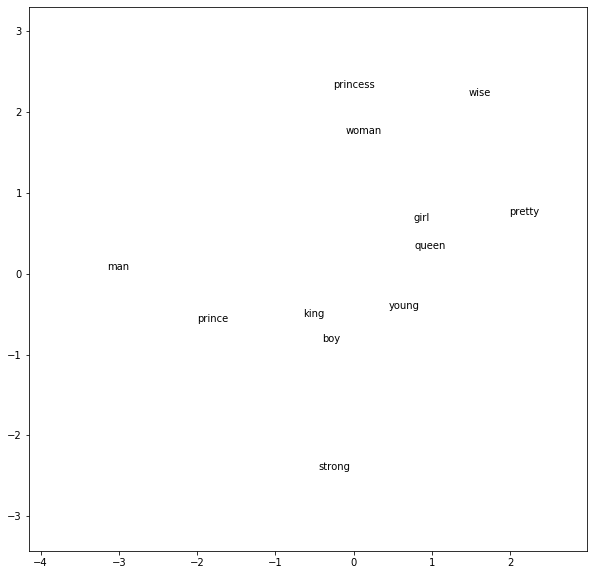

In [32]:
fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()

#### Word embedding with 3 dimentions

In [43]:
# for 3d visualization
model = run_model(3)

In [44]:
# Now the hidden layer (W1 + b1) is actually the word look up table
model.layers[0].get_weights()

[array([[-1.3460636 ,  1.8341794 ,  1.7490449 ],
        [-0.83244175,  0.429705  , -2.5486848 ],
        [ 0.71019155, -0.43158957, -1.4976863 ],
        [-0.10482182, -0.3556644 ,  1.40731   ],
        [ 0.8778619 , -1.2787489 ,  1.2695436 ],
        [-0.00391587,  1.7243513 ,  0.9223452 ],
        [-1.4382862 , -2.1928606 , -0.24805127],
        [ 1.2838901 ,  0.85910213,  1.6835253 ],
        [-0.4527602 ,  0.34544253, -1.8682272 ],
        [ 0.89833236,  0.02186978,  0.80485505],
        [-0.28493378, -0.3893257 , -0.92167115],
        [ 1.120477  , -0.6261617 , -0.14975835]], dtype=float32),
 array([ 0.32034606,  0.19053742, -0.21747728], dtype=float32)]

In [45]:
W = model.layers[0].get_weights()[0]
print ("Weights:")
print (W)
b = model.layers[0].get_weights()[1]
print ("Bias:")
print (b)

Weights:
[[-1.3460636   1.8341794   1.7490449 ]
 [-0.83244175  0.429705   -2.5486848 ]
 [ 0.71019155 -0.43158957 -1.4976863 ]
 [-0.10482182 -0.3556644   1.40731   ]
 [ 0.8778619  -1.2787489   1.2695436 ]
 [-0.00391587  1.7243513   0.9223452 ]
 [-1.4382862  -2.1928606  -0.24805127]
 [ 1.2838901   0.85910213  1.6835253 ]
 [-0.4527602   0.34544253 -1.8682272 ]
 [ 0.89833236  0.02186978  0.80485505]
 [-0.28493378 -0.3893257  -0.92167115]
 [ 1.120477   -0.6261617  -0.14975835]]
Bias:
[ 0.32034606  0.19053742 -0.21747728]


In [46]:
vectors = W + b
print (vectors)

[[-1.0257175   2.0247169   1.5315676 ]
 [-0.5120957   0.6202424  -2.7661622 ]
 [ 1.0305376  -0.24105215 -1.7151636 ]
 [ 0.21552424 -0.16512698  1.1898327 ]
 [ 1.198208   -1.0882114   1.0520663 ]
 [ 0.31643018  1.9148887   0.70486796]
 [-1.1179402  -2.0023232  -0.46552855]
 [ 1.6042361   1.0496396   1.466048  ]
 [-0.13241413  0.53598    -2.0857046 ]
 [ 1.2186785   0.2124072   0.5873778 ]
 [ 0.03541228 -0.19878829 -1.1391485 ]
 [ 1.4408231  -0.43562427 -0.36723563]]


In [47]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2', 'x3'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2', 'x3']]
w2v_df

,word,x1,x2,x3
0,woman,-1.025717,2.024717,1.531568
1,man,-0.512096,0.620242,-2.766162
2,prince,1.030538,-0.241052,-1.715164
3,wise,0.215524,-0.165127,1.189833
4,pretty,1.198208,-1.088211,1.052066
5,princess,0.316430,1.914889,0.704868
6,strong,-1.117940,-2.002323,-0.465529
7,queen,1.604236,1.049640,1.466048
8,king,-0.132414,0.535980,-2.085705
9,girl,1.218678,0.212407,0.587378


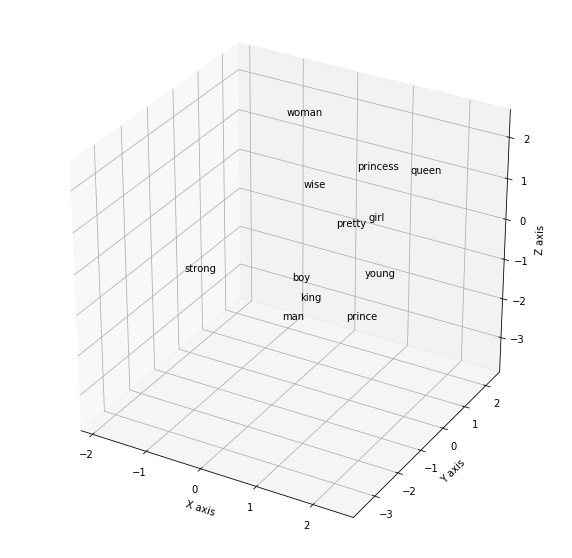

In [48]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

z_points = w2v_df['x1']
x_points = w2v_df['x2']
y_points = w2v_df['x3']

for word, x1, x2, x3 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2'],w2v_df['x3']):
    label = '%s' % (word)
    ax.text(x1, x2, x3, label)
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
z_axis_min = np.amin(vectors, axis=0)[2] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
z_axis_max = np.amax(vectors, axis=0)[2] + PADDING


ax.set_xlim(x_axis_min,x_axis_max)
ax.set_ylim(z_axis_min,z_axis_max)
ax.set_zlim(z_axis_min,z_axis_max)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()